# MNIST
この章ではMNISTデータを使います．これは高校生が書いた70,000個の手書き数字の画像データです．

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

データ項目の意味
- DESCR :データセットの詳細を表しています．
- data：1インスタンスに対して　１行，1特徴に対して1列の配列で表現されたデータ
- target：ラベルを表す数値

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


70000個の画像があり，1画像あたり784個の数値でデータが表されているます．784=28×28ピクセルのため，この数値になっています．

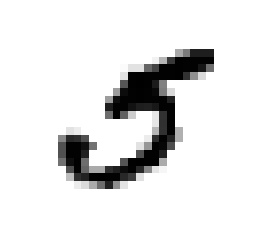

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [4]:
y[36000]

5.0

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/Users/syuheyk/.pyenv/versions/anaconda3-4.3.1/envs/py3.6.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

# Performance Measures
## Measuring Accuracy Using Cross-Validation


In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9508 ,  0.96115,  0.93565])

In [10]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [11]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9058 ,  0.9128 ,  0.91035])

つまり，5を表すデータはそもそも全体の10%程度しかないということ．どんな画像が来ても"5ではない"と判定する予測器でも90%当ててしまうということです．

これが意味することは，一般的にaccuracyはモデルのパフォーマンス指標として好まれないということです．特に，skewed datasetsに対しては(いくつかのクラスが他よりも多く実現するクラス)．

## Confusion Matrix
より良いモデル評価の方法はconfusion matrixを見ることです．考え方は，クラスAのインスタンスがクラスBと判定されてしまう回数を数えるというもの．

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predictは，cross_val_scoreと同じような関数だがスコア評価するのではなく，テストデータに対する予測を行う関数です．これを元に以下の感じでconfusion matrixを作ることができます．

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53326,  1253],
       [ 1795,  3626]])

↑の出力の意味：各行は実際のクラスで1行目が外れ・2行目が当たり，各列は予測したクラスで1列目が外れと予測・2列目が当たりと予測．今回で言えば，1行1列は52,763個の画像が正しく5ではない(外れ・外れ)と予測され，4267個の画像が正しく5である(当たり・当たり)と予測されていることがわかる．注目すべきはそれ以外の要素で，1154個の画像が5なのに5ではないと予測(当たり・外れ)されてしまった数，1816個の画像が5ではないのに5と予測(外れ・当たり)と予測されてしまった数である．

これから，accuracyだけみていては正確さは測れないということで，代わりの指標として以下のものがある
$$\text{precision}=\frac{TP}{TP+FP}$$
$$\text{recall}=\frac{TP}{TP+FN}$$
ここで，$TP$はtrue-positiveの数(当たり・当たり)，$FP$はfalse positiveの数(外れ・当たり)，$FN$はfalse negativeの数(当たり・外れ)．

## Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.74318507891
0.668880280391


最初にみた時より5-detectorはすごくは見えないでしょう．

precisionとrecallを組み合わせた指標$F_1$がよく使われます．

$$F_1=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2\times\frac{precision\times recall}{precision+recall}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

$F_1$はprecisionとrecallが同じような値になるようにモデルを作りたいときに便利です．ただし$F_1$を採用することが良いというわけではないので，precisionを用いるべきか，recallを用いるべきか，モデルの使用目的にそって評価指標を選んでください．

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.70407766990291254

## Precsion/Recall Tradeoff

残念ながらprecisionとrecallを同時に高めることはできず，トレードオフが発生します．
これを見るためにSGD Classifierでprecisionとrecallの様子をみてみましょう．
decision_function()メソッドは各インスタンスのスコアを返す関数です．これを使ってこのスコアと閾値(threshold)をもとに予測値を出すことができます．
スコアは以下の感じ．

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-35448.55830017])

これは[some_digit]のスコアが14148であるということを表します．
閾値を0として予測値を出すと以下の感じ．

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

値がTrueで返って来ているということは，予測はこの画像は5ですと言っています．
閾値を200000とすると次のようになります．

In [18]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

値がFalseになってしまいました．つまりこの画像は5ではないという言っていることになります．
閾値はどのくらいの値を使うべきでしょうか？
そのためにはすべてのインスタンスのスコアを計算してprecisionとrecallを計算する必要があります．

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")[:,1]
# テキストのコードに[:,1]を追加しています．cross_val_predictの返り値は二次元なのでどの列の値かを指定して1次元にする必要があります．

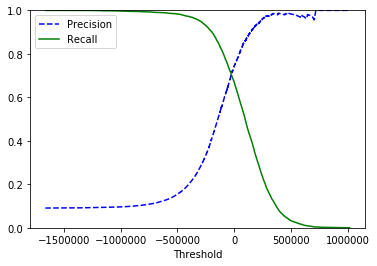

In [20]:
# precision と recall の計算
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# グラフの描画
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## The ROC Curve
The receiver operating characteristic curve とは，二項判別器で使われる，precision/recallとは別のもう一つのツールです．ROCカーブはtrue positive rate (TPR=recall)対false positive rate (FPR)をプロットします．FPRは，誤って正しいと判定されたインスタンスの比率です．値としては1 - true negative rate (TNR) と等しく，TNRは間違いであると正しく判定されたインスタンスうの比率です．TNRはspecificityとも呼ばれます．
ROC curveをプロットしてみましょう！

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

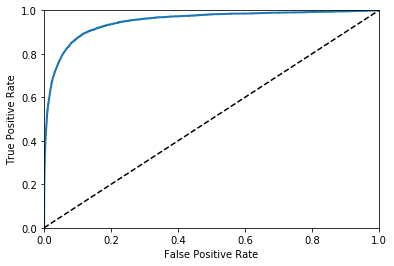

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,  0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

recall(=TRR)が高いほど，false positive(FPR)も高くなることがわかります．完全にランダムな判別器は黒点線になるはずで，この黒点線からいかに離れたROCを得られるかで良い判別器かどうかを判定することができます．

Area under the curve(AUC)を見ることで，判別器を比較することもできます．完璧な変別器はROCやAUCが1になります．一方で上のような完全ランダムな判別器はROCやAUCが0.5になります(線の下の領域の面積)．

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.94944564666732312

Random Forestで判別器を作ってROCとAUCを比較してみましょう．RandomForestClassifierの各インスタンスに対するスコアを取得する必要がありますが，RandomForestClassifierはdecision_function()メソッドをもっていないかわりに，predict_proba()メソッドを持っています．predict_proba()メソッドは，行がインスタンス，列がクラスに分かれていて，各セルにその列のクラスに含まれる確率が格納されている配列を返します．

しかし，ROCカーブをプロットするのに必要なのは確率ではなく，スコアなのでpositive class の確率をそのままスコアに採用します．

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [25]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

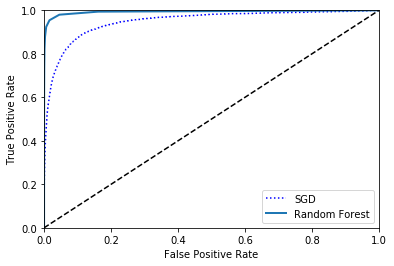

In [26]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

RandomForestClassifierのROCの方がかなり良い結果に見えるます．ROC AUCスコアをみてもそんな感じです．

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.99351096732768163

# Multiclass Classification


In [28]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 0.])

In [29]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[  28287.39122951, -576075.44752505, -331888.58191114,
        -168954.05206377, -378116.75388773,  -35448.55830017,
        -738219.59999871, -395516.22080985, -630087.77538108,
        -826310.84262416]])

In [30]:
np.argmax(some_digit_scores)

0

In [31]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [32]:
sgd_clf.classes_[5]

5.0

Scikit-LearnではOneVsOneClassifierとOneVsRestClassifierが使えます．
ここではSGDClassifierをベースとしたOneVsOneClassifierを使ってみます．

In [33]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

/Users/syuheyk/.pyenv/versions/anaconda3-4.3.1/envs/py3.6.0/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[ 5.]
45


In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [35]:
forest_clf.predict_proba([some_digit])

array([[ 0.2,  0. ,  0. ,  0. ,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85407918,  0.86184309,  0.8253238 ])

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91246751,  0.90859543,  0.90748612])

# Error Analysis

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    4,   22,   10,   10,   46,   46,    9,   39,    3],
       [   2, 6458,   42,   28,    5,   41,    7,   14,  132,   13],
       [  59,   33, 5318,  109,   79,   25,   95,   51,  174,   15],
       [  53,   36,  130, 5350,    4,  230,   36,   62,  141,   89],
       [  21,   26,   36,   11, 5336,    9,   58,   33,   80,  232],
       [  84,   39,   32,  188,   73, 4617,  115,   27,  159,   87],
       [  38,   24,   43,    2,   44,   96, 5617,    8,   45,    1],
       [  26,   17,   66,   31,   60,    9,    6, 5812,   16,  222],
       [  56,  142,   65,  152,   15,  156,   55,   29, 5040,  141],
       [  45,   26,   27,   87,  147,   39,    2,  212,   75, 5289]])

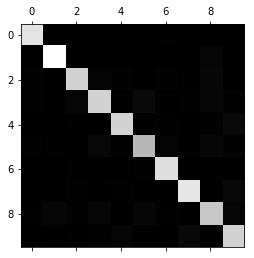

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

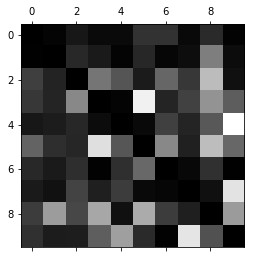

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
# 著者のGitHub にあるjupyter notebookから引用
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

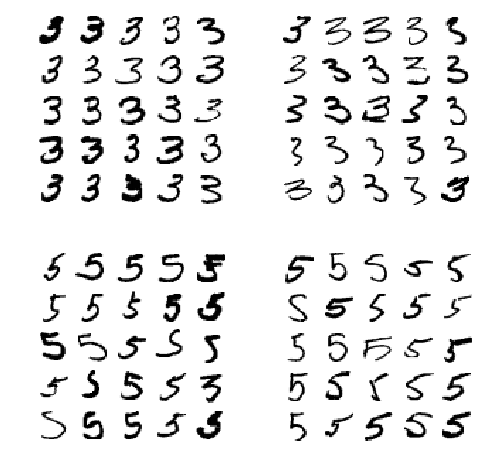

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

# Multioutput Classification

In [45]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test = noise

y_train_mod = X_train
y_test_mod = X_test

In [48]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [49]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)

ValueError: Found array with dim 3. Estimator expected <= 2.